In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/kislay960/Data-Science-Practice/master/titanic.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
cols_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']

In [5]:
data = data.drop(cols_to_drop,axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

In [8]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [67]:
data = data.fillna(data['Age'].median())

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [69]:
y = data[['Survived']]

In [70]:
x = data[['Pclass',"Sex","Age","SibSp","Parch","Fare"]]

In [71]:
x.shape,y.shape

((891, 6), (891, 1))

In [72]:
def entropy(col):
  counts = np.unique(col,return_counts=True)
  N = float(col.shape[0])
  ent = 0.0
  for ix in counts[1]:
    p = ix/N
    ent -= p*np.log2(p)
  return ent

In [73]:
def divide_data(x_data,fkey,fval):
  x_right = pd.DataFrame([],columns= x_data.columns)
  x_left = pd.DataFrame([],columns= x_data.columns)
  for ix in range(x_data.shape[0]):
    val = x_data[fkey].loc[ix]
    if val>fval:
      x_right = x_right.append(x_data.loc[ix])
    else:
      x_left = x_left.append(x_data.loc[ix])
  return x_left,x_right

In [74]:
def information_gain(x_data,fkey,fval):
  left,right = divide_data(x_data,fkey,fval)
  l = float(left.shape[0])/x_data.shape[0]
  r = float(right.shape[0])/x_data.shape[0]
  if left.shape[0] == 0 or right.shape[0] == 0:
    return -1000000
  i_gain = entropy(x_data.Survived) - (l*entropy(left.Survived)+r*entropy(right.Survived))
  return i_gain

In [75]:
for fx in x.columns:
  print(fx)
  print(information_gain(data,fx,data[fx].mean()))

Pclass
0.07579362743608165
Sex
0.2176601066606142
Age
0.0008836151229467681
SibSp
0.009584541813400071
Parch
0.015380754493137916
Fare
0.042140692838995464


In [76]:
class DecisionTree:

  def __init__(self,depth=0,max_depth=5):
    self.left = None
    self.right = None
    self.fkey = None
    self.fval = None #Threshold value
    self.max_depth = max_depth
    self.depth = depth
    self.target = None

  def train(self,x_train):
    features = ['Pclass',"Sex","Age","SibSp","Parch","Fare"]
    info_gains = []
    for ix in features:
      i_gain = information_gain(x_train,ix,x_train[ix].mean())
      info_gains.append(i_gain)
    
    self.fkey = features[np.argmax(info_gains)]
    self.fval = x_train[self.fkey].mean()
    print(self.fkey)
    
    data_left,data_right = divide_data(x_train, self.fkey, self.fval)
    data_left = data_left.reset_index(drop = True)
    data_right = data_right.reset_index(drop = True)

    #if node is a leaf node
    if data_left.shape[0] == 0 or data_right.shape[0] == 0:
      if x_train.Survived.mean() >= 0.5:
        self.target = 'Survive'
      else:
        self.target = 'Dead'
      return

    #Method 2 (early stopping)
    if(self.depth>=self.max_depth):
      if x_train.Survived.mean() >= 0.5:
        self.target = 'Survive'
      else:
        self.target = 'Dead'
      return
    
    #recursive call
    self.left = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
    self.left.train(data_left)
    self.right = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
    self.right.train(data_right)

    if x_train.Survived.mean() >= 0.5:
      self.target = 'Survive'
    else:
      self.target = 'Dead'
    return

    
  def predict(self,test):
    if test[self.fkey]>self.fval:
        #go to right
      if self.right is None:
        return self.target
      return self.right.predict(test)
    else:
      if self.left is None:
        return self.target
      return self.left.predict(test)


In [77]:
split = int(0.7*data.shape[0])
train_data = data[:split]
test_data = data[split:]
test_data = test_data.reset_index(drop=True)

In [78]:
dt = DecisionTree()
dt.train(train_data)

Sex
Pclass
Age
SibSp
Pclass
Age
Age
SibSp
Parch
Pclass
SibSp
Fare
Parch
Age
Pclass
Age
Age
Parch
Age
Fare
Fare
SibSp
Age
Fare
Fare
Fare
Age
Parch
Fare
Fare
Fare
Age
Fare
Parch
Fare
Pclass
Pclass
Fare
Fare
SibSp
Fare
Age
Fare
Pclass
SibSp
Age
Age
Age
Pclass
Age
SibSp
Fare
SibSp
Age
Parch
SibSp
SibSp
Age
Age
Age
Parch
Age
Age


In [79]:
print(dt.fkey)
print(dt.left.fkey)
print(dt.right.fkey)

Sex
Pclass
Fare


In [80]:
y_pred = []
for ix in range(test_data.shape[0]):
  y_pred.append(dt.predict(test_data.loc[ix]))

In [81]:
y_actual = test_data[['Survived']]

In [82]:
le = LabelEncoder()
y_pred = le.fit_transform(y_pred)

In [83]:
y_pred = np.array(y_pred).reshape((-1,1))

In [84]:
acc = np.sum(np.array(y_pred)==np.array(y_actual))/y_pred.shape[0]

In [85]:
acc

0.8171641791044776

sklearn

In [86]:
from sklearn.tree import DecisionTreeClassifier

In [97]:
sk_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)

In [98]:
input_cols = ['Pclass',"Sex","Age","SibSp","Parch","Fare"]
output_cols = ['Survived']
sk_tree.fit(train_data[input_cols],train_data[output_cols])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [99]:
sk_tree.score(test_data[input_cols],test_data[output_cols])

0.8283582089552238

In [100]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

In [101]:
dot_data = StringIO()
export_graphviz(sk_tree,out_file=dot_data,filled=True,rounded=True)

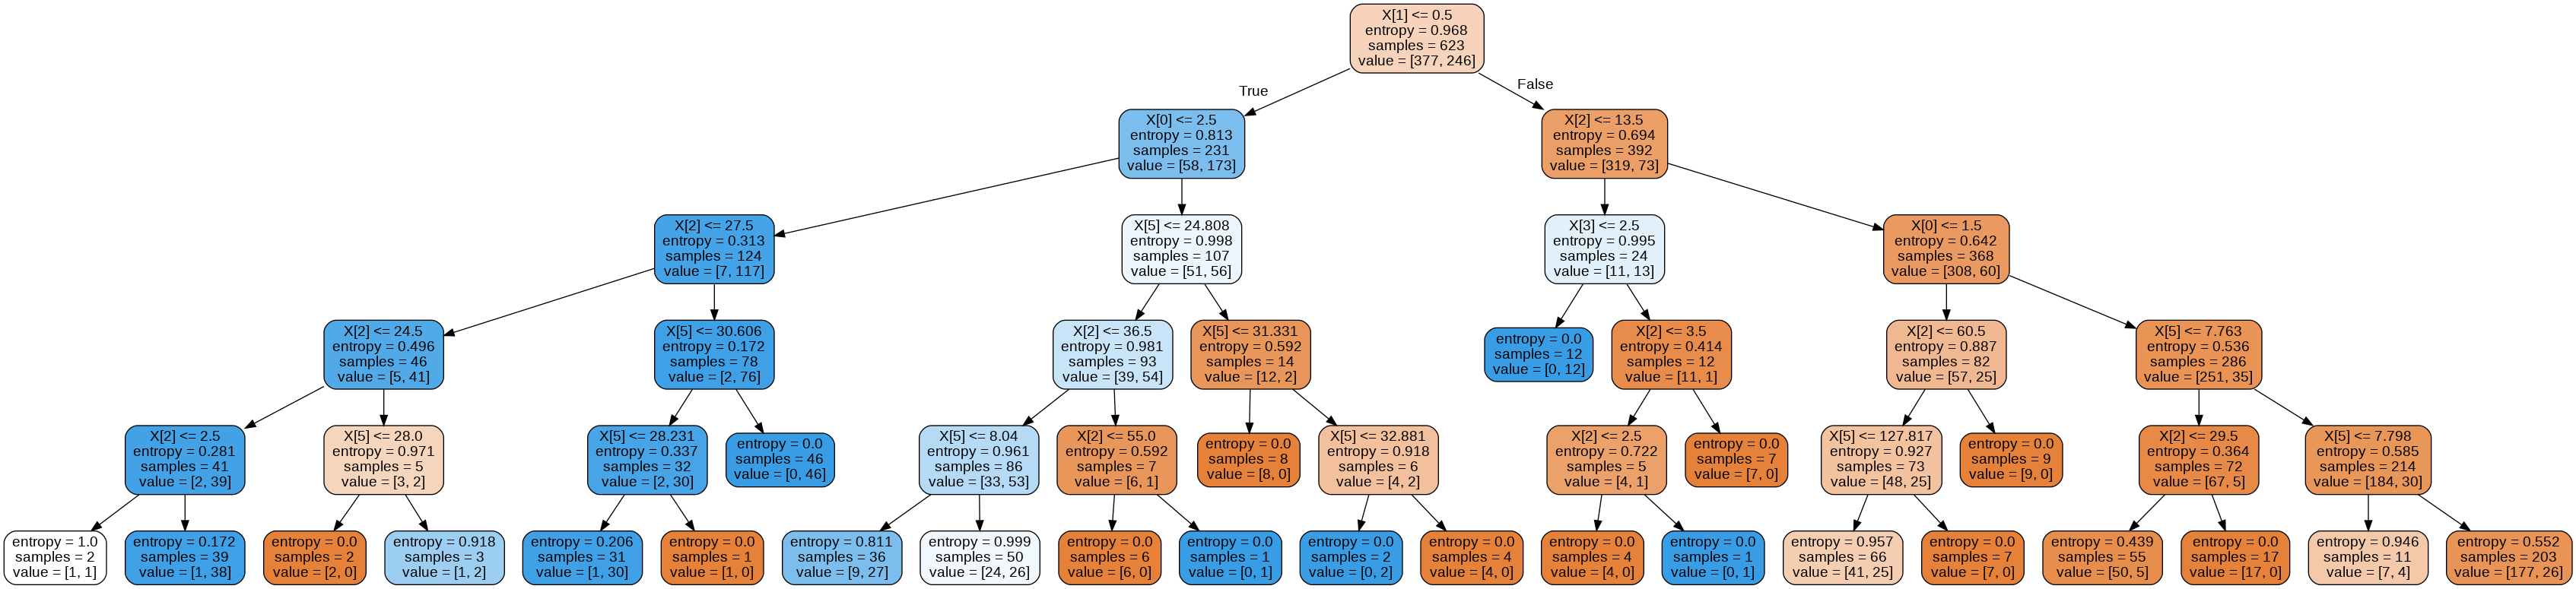

In [102]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

random forest

In [103]:
x_train = train_data[input_cols]
y_train = np.array(train_data[output_cols]).reshape((-1,))
x_test = test_data[input_cols]
y_test = np.array(test_data[output_cols]).reshape((-1,))

In [104]:
sk_tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
sk_tree.fit(x_train,y_train)
sk_tree.score(x_train,y_train)

0.8443017656500803

In [105]:
sk_tree.score(x_test,y_test)

0.8283582089552238

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
rf = RandomForestClassifier(n_estimators=10,criterion='entropy',max_depth=5)

In [116]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [117]:
rf.score(x_train,y_train)

0.85553772070626

In [118]:
rf.score(x_test,y_test)

0.8208955223880597

In [120]:
from sklearn.model_selection import cross_val_score

In [127]:
acc = cross_val_score(RandomForestClassifier(n_estimators=20,criterion='entropy',max_depth=6),x_train,y_train,cv=5).mean()

In [128]:
acc

0.8137677419354838

In [129]:
acc_list = []
for i in range(1,50):
  acc = cross_val_score(RandomForestClassifier(n_estimators=i,max_depth=6),x_train,y_train,cv=5).mean()
  acc_list.append(acc)

In [130]:
acc_list

[0.715883870967742,
 0.752916129032258,
 0.7945548387096775,
 0.7977290322580645,
 0.8009935483870967,
 0.8090322580645161,
 0.8218580645161291,
 0.8170193548387097,
 0.7977419354838708,
 0.8170064516129033,
 0.8202064516129031,
 0.8121677419354839,
 0.8105419354838709,
 0.8186064516129032,
 0.8185677419354839,
 0.8169806451612903,
 0.8153935483870967,
 0.8250322580645161,
 0.8089806451612903,
 0.8249935483870967,
 0.8137419354838709,
 0.8153935483870967,
 0.8201935483870969,
 0.8185935483870967,
 0.8137677419354838,
 0.8250580645161291,
 0.8266064516129032,
 0.8089419354838709,
 0.8234064516129032,
 0.8185806451612903,
 0.8137935483870967,
 0.820232258064516,
 0.8169806451612903,
 0.8234193548387096,
 0.820258064516129,
 0.8249806451612903,
 0.8185935483870967,
 0.8249935483870967,
 0.8185548387096775,
 0.8185935483870967,
 0.8266580645161291,
 0.8185806451612903,
 0.8201806451612903,
 0.816941935483871,
 0.8169548387096774,
 0.8137548387096775,
 0.8233935483870967,
 0.815380645161290

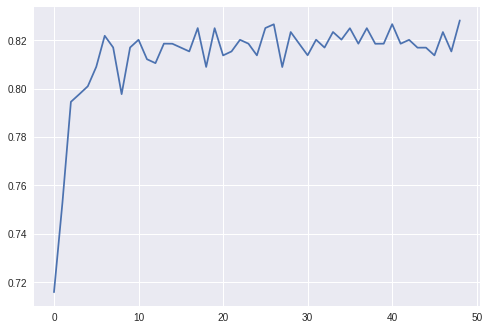

In [131]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.plot(acc_list)
plt.show()

In [132]:
np.argmax(acc_list)

48